# Lending Club - Predicting loan application rejections

_We are trying to forecast the number of loans rejected per month using Arima Time Series and LTSM models_

https://www.lendingclub.com/info/download-data.action

In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import seaborn as sns

%matplotlib inline

_Import the Lending Club rejection Application Datae from the Lending Club website_

In [2]:
df2017Q1 = pd.read_csv('RejectStats_2017Q1.csv',
                       low_memory=False, skiprows=[0]).iloc[:, [1]]
df2017Q2 = pd.read_csv('RejectStats_2017Q2.csv',
                       low_memory=False, skiprows=[0]).iloc[:, [1]]
df2017Q3 = pd.read_csv('RejectStats_2017Q3.csv',
                       low_memory=False, skiprows=[0]).iloc[:, [1]]
df2017Q4 = pd.read_csv('RejectStats_2017Q4.csv',
                       low_memory=False, skiprows=[0]).iloc[:, [1]]
df2018Q1 = pd.read_csv('RejectStats_2018Q1.csv',
                       low_memory=False, skiprows=[0]).iloc[:, [1]]
df2018Q2 = pd.read_csv('RejectStats_2018Q2.csv',
                       low_memory=False, skiprows=[0]).iloc[:, [1]]
df2018Q3 = pd.read_csv('RejectStats_2018Q3.csv',
                       low_memory=False, skiprows=[0]).iloc[:, [1]]
df2018Q4 = pd.read_csv('RejectStats_2018Q4.csv',
                       low_memory=False, skiprows=[0]).iloc[:, [1]]
df2019Q1 = pd.read_csv('RejectStats_2019Q1.csv',
                       low_memory=False, skiprows=[0]).iloc[:, [1]]

In [3]:
loans = [df2017Q1, df2017Q2, df2017Q3, df2017Q4,
         df2018Q1, df2018Q2, df2018Q3, df2018Q4, df2019Q1]
df = pd.concat(loans)
df.to_csv('RejectedLoans.csv')

_Only import the application data as the data_

In [4]:
df = pd.read_csv('RejectedLoans.csv')
df = df.drop('Unnamed: 0', axis=1)

In [5]:
df = df.dropna()

In [6]:
df.head()

,Application Date
0,2017-01-01
1,2017-01-01
2,2017-01-01
3,2017-01-01
4,2017-01-01


In [7]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19158655 entries, 0 to 19158654
Data columns (total 1 columns):
Application Date    object
dtypes: object(1)
memory usage: 292.3+ MB


((19158655, 1), None)

_The forecast will be computed on a weekly basis_

In [8]:
# https://stackoverflow.com/questions/45281297/group-by-week-in-pandas#45281439
# http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html
df.rename(columns={'Application Date': 'Application_Date'}, inplace=True)
df['Count'] = 1
df['Application_Date'] = pd.to_datetime(
    df['Application_Date']) - pd.to_timedelta(7, unit='d')
df = df.groupby([pd.Grouper(key='Application_Date', freq='W-MON')]
                )['Count'].sum().reset_index().sort_values('Application_Date')

In [9]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 117
Data columns (total 2 columns):
Application_Date    118 non-null datetime64[ns]
Count               118 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


((118, 2), None)

In [10]:
df.head()

,Application_Date,Count
0,2016-12-26,19659
1,2017-01-02,119903
2,2017-01-09,112116
3,2017-01-16,110457
4,2017-01-23,108717


In [11]:
# I will drop the 2016 date.
df = df.loc[1:, :]

In [12]:
df.head()

,Application_Date,Count
1,2017-01-02,119903
2,2017-01-09,112116
3,2017-01-16,110457
4,2017-01-23,108717
5,2017-01-30,107435


In [13]:
df.shape

(117, 2)

_Our dataset is not down to 117 rows, which is 117 weeks of loan data._

In [14]:
df['Application_Date'] = pd.to_datetime(df['Application_Date'])

_What is the time range of the data_

In [15]:
print("Starts date {}".format(df['Application_Date'].min()))
print("Ends date {}".format(df['Application_Date'].max()))

Starts date 2017-01-02 00:00:00
Ends date 2019-03-25 00:00:00


In [16]:
dfIndex = df.set_index('Application_Date')
dfIndex.index

DatetimeIndex(['2017-01-02', '2017-01-09', '2017-01-16', '2017-01-23',
               '2017-01-30', '2017-02-06', '2017-02-13', '2017-02-20',
               '2017-02-27', '2017-03-06',
               ...
               '2019-01-21', '2019-01-28', '2019-02-04', '2019-02-11',
               '2019-02-18', '2019-02-25', '2019-03-04', '2019-03-11',
               '2019-03-18', '2019-03-25'],
              dtype='datetime64[ns]', name='Application_Date', length=117, freq=None)

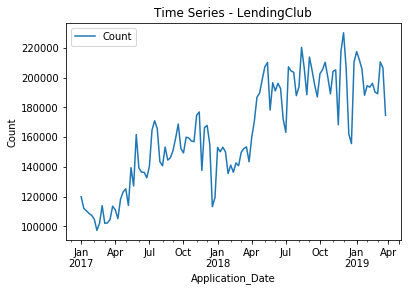

In [17]:
dfIndex.plot()
plt.title('Time Series - LendingClub')
plt.xlabel('Application_Date')
plt.ylabel('Count')
plt.show()

_The data is not stationary, therefore we have to take the difference_

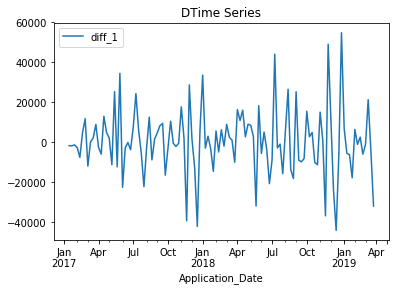

In [69]:
dfIndex['diff_1'] = dfIndex.Count - dfIndex.Count.shift()
dfIndex.plot(y='diff_1')
plt.title('DTime Series')
plt.show()

In [19]:
dfIndex.head()

,Count,diff_1
Application_Date,,
2017-01-02,119903,NaN
2017-01-09,112116,-7787.0
2017-01-16,110457,-1659.0
2017-01-23,108717,-1740.0
2017-01-30,107435,-1282.0


In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
dfIndex = dfIndex.dropna()
dfIndex = dfIndex.drop('diff_1', axis=1)
decomposition = seasonal_decompose(dfIndex, model='additive')

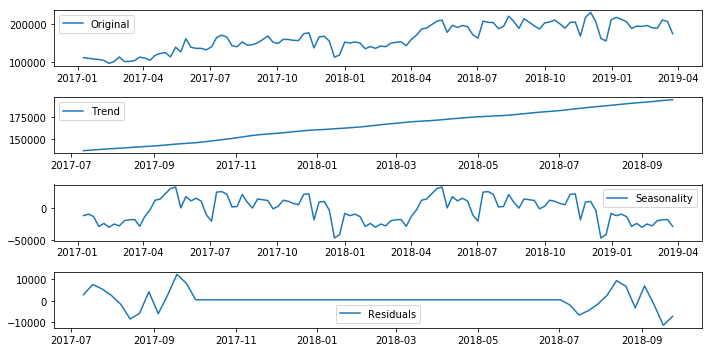

In [21]:
plt.figure(figsize=(10, 5))
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid


plt.subplot(411)
# plt.title('Original')
plt.plot(dfIndex.Count, label='Original')
#plt.plot(dfIndex.diff_1, label='Diff_1')
plt.legend(loc='best')

plt.subplot(412)
# plt.title('Trend')
plt.plot(trend, label='Trend')
#plt.plot(dfIndex.diff_1, label='Diff_1')
plt.legend(loc='best')

plt.subplot(413)
# plt.title('Seasonality')
plt.plot(seasonal, label='Seasonality')
#plt.plot(dfIndex.diff_1, label='Diff_1')
plt.legend(loc='best')

plt.subplot(414)
# plt.title('Residuals')
plt.plot(residuals, label='Residuals')
#plt.plot(dfIndex.diff_1, label='Diff_1')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [22]:
dfIndex.head()

,Count
Application_Date,
2017-01-09,112116
2017-01-16,110457
2017-01-23,108717
2017-01-30,107435
2017-02-06,104842


_PACF for both the initial and differenced time series._

Text(0.5, 1.0, 'Unrate PACF')

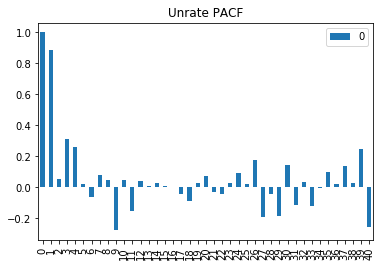

In [23]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(dfIndex.Count))
x_acf.plot(kind='bar')
plt.title("Unrate PACF")

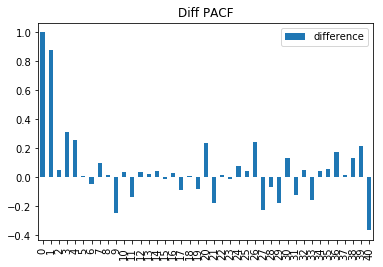

In [24]:
x_acf = pd.DataFrame(pacf(dfIndex.Count.iloc[1:]))
x_acf.plot(kind='bar')
plt.title("Diff PACF")
plt.legend(['difference'])

So both the original and the difference time series has 1 strong autocorrelation. This indicates that we should look into a p of 1 for our models.  I will try modeling with using the auto arima to see what the model comes up with.

In [25]:
from statsmodels.tsa.stattools import adfuller

# raw data
acdf_test = adfuller(dfIndex['Count'], autolag='AIC')
df_output = pd.Series(acdf_test[0:4], index=[
                      'Test Statistic',
                      'p-value',
                      '#lags used',
                      '#nobs used'])
print('raw data\n', df_output)
for k, v in acdf_test[4].items():
    print(k, v)

raw data
 Test Statistic     -1.653998
p-value             0.454956
#lags used          3.000000
#nobs used        112.000000
dtype: float64
1% -3.4901313156261384
5% -2.8877122815688776
10% -2.5807296460459184


_From this test, we see the time series is not stationary because the p-value is > 0.05_

__Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)__
    * The ACF/PACF plots don't show a quick drop-off therefore it is not stationary.
    * This data is non-stationary as a high number of previous observations are correlated with future values.
    * Confidence intervals are the shaded area therefore any point outside is considered correlated.

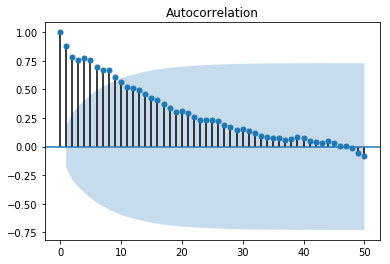

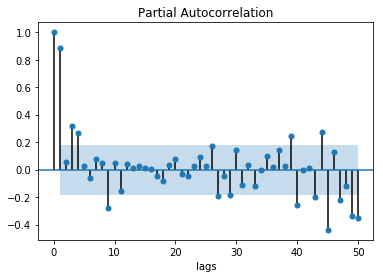

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_acf(dfIndex['Count'], lags=50)
plot_pacf(dfIndex['Count'], lags=50)
plt.xlabel('lags')
plt.show()

## Building models.

So our both time series has 1 strong autocorrelation. Let's build some ARIMA models to experiment and see how we do!

We're going to build a series of models to evaluate, each with slightly different parameters for the ARIMA. Note that the parameteres are passed in (p, d, q) order, corresponding to the AR, I, and MA portions respectively.

Recall how we interpret those attributes. The AR is the past values, I is the level of differencing, and MA is adjusting to past errors.

_Now we need to find the best model, one which has the lowesr AIC._

In [71]:
# https://www.alkaline-ml.com/pmdarima/tips_and_tricks.html
from pmdarima.arima import auto_arima
stepwise_fit = auto_arima(dfIndex['Count'],
                          start_p=0, start_q=0,
                          max_p=13, max_q=13, m=13,
                          start_P=0, start_Q=0,
                          seasonal=True,
                          d=1, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          random_state=42,
                          n_fits=3,
                          stepwise=True) 
stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 13); AIC=2337.103, BIC=2342.353, Fit time=0.025 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 13); AIC=2301.396, BIC=2311.896, Fit time=0.222 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 13); AIC=2287.446, BIC=2297.945, Fit time=0.652 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 13); AIC=2287.025, BIC=2300.150, Fit time=0.251 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 13); AIC=2294.004, BIC=2304.504, Fit time=0.183 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 13); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 13); AIC=2328.712, BIC=2336.587, Fit time=0.037 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 13); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 13); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 13); AIC=229

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  116
Model:             SARIMAX(0, 1, 2)x(1, 1, 1, 13)   Log Likelihood               -1134.857
Date:                            Fri, 28 Jun 2019   AIC                           2281.713
Time:                                    21:58:48   BIC                           2297.463
Sample:                                         0   HQIC                          2288.091
                                            - 116                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -315.9325    725.235     -0.436      0.663   -1737.367    1105.502
ma.L1         -0.3026      0.238     -1.272      0.204      -0.769       0.164
ma.L2         -0.2153      0.198     -1.086      0.278      -0.604       0.173
ar.S.L13      -0.2300      0.210     -1.096      0.273      -0.641       0.181
ma.S.L13      -0.6329      0.261     -2.428      0.015      -1.144      -0.122
sigma2      4.291e+08      0.001   7.23e+11      0.000    4.29e+08    4.29e+08
===================================================================================
Ljung-Box (Q):                       38.70   Jarque-Bera (JB):                 0.85
Prob(Q):                              0.53   Prob(JB):                         0.65
Heteroskedasticity (H):               1.30   Skew:                             0.14
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.64e+27. Standard errors may be unstable.
"""

In [28]:
dfIndex.shape

(116, 1)

_Separate out the train and test for modeling.  I will use 8 weeks of data for the test data which leaves 108 weeks for training._

In [29]:
train, test = dfIndex[:108], dfIndex[108:]
train.shape, test.shape

((108, 1), (8, 1))

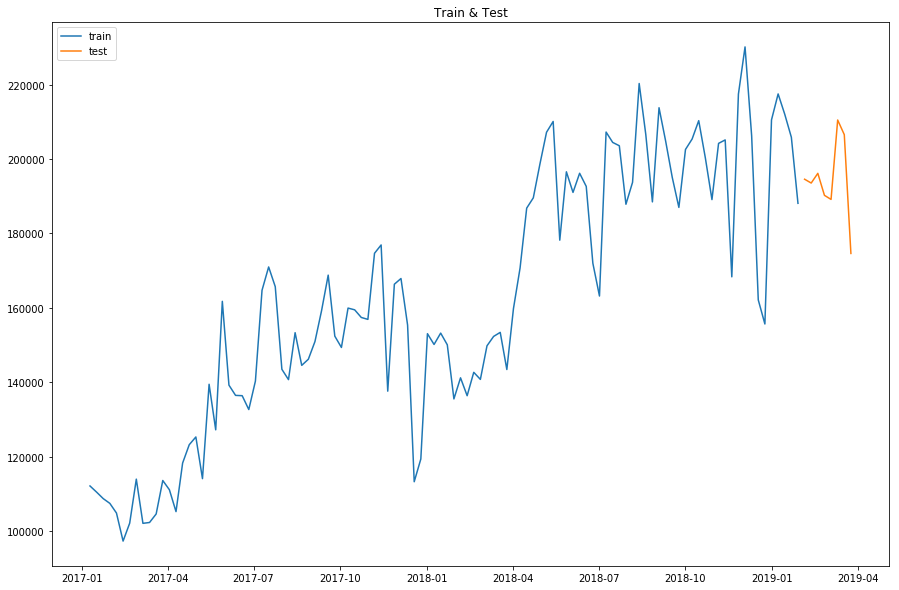

In [30]:
plt.figure(figsize=(15, 10))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.title('Train & Test')
plt.legend(loc='upper left')
plt.show()

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['Count'], order=(0, 1, 2), seasonal_order=(
    1, 1, 1, 13), enforce_invertibility=True)
results = model.fit()
results.summary()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Count   No. Observations:                  108
Model:             SARIMAX(0, 1, 2)x(1, 1, 1, 13)   Log Likelihood               -1044.654
Date:                            Fri, 28 Jun 2019   AIC                           2099.308
Time:                                    16:08:47   BIC                           2112.025
Sample:                                01-09-2017   HQIC                          2104.445
                                     - 01-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2829      0.204     -1.388      0.165      -0.682       0.117
ma.L2         -0.1902      0.179     -1.061      0.289      -0.541       0.161
ar.S.L13      -0.1997      0.212     -0.944      0.345      -0.614       0.215
ma.S.L13      -0.5822      0.255     -2.280      0.023      -1.083      -0.082
sigma2       3.93e+08   2.64e-10   1.49e+18      0.000    3.93e+08    3.93e+08
===================================================================================
Ljung-Box (Q):                       38.78   Jarque-Bera (JB):                 1.68
Prob(Q):                              0.53   Prob(JB):                         0.43
Heteroskedasticity (H):               1.56   Skew:                             0.14
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.24e+34. Standard errors may be unstable.
"""

In [32]:
pred = pd.DataFrame(stepwise_fit.predict(n_periods=8),
                    index=test.index)
pred.columns = ['Predicted_Num_Loans']

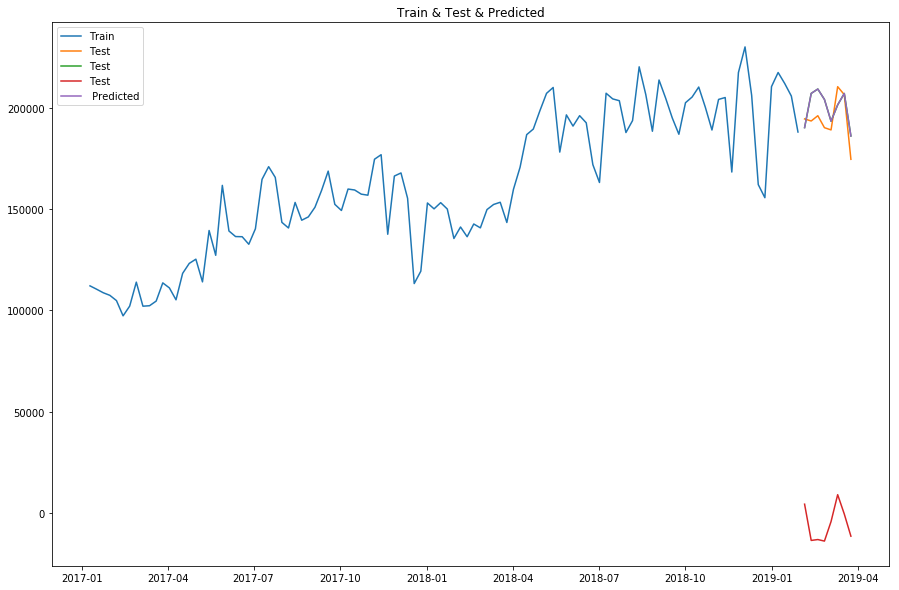

In [72]:
plt.figure(figsize=(15, 10))
plt.title('Train & Test & Predicted')
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred, label=' Predicted')
plt.legend(loc='upper left')
plt.show()

In [34]:
test['Predicted'] = pred
test['Error'] = test['Count']-test['Predicted']
test

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Count,Predicted,Error
Application_Date,,,
2019-02-04,194570,190282.514309,4287.485691
2019-02-11,193545,207165.140204,-13620.140204
2019-02-18,196149,209330.691465,-13181.691465
2019-02-25,190241,204185.997558,-13944.997558
2019-03-04,189141,193419.028761,-4278.028761
2019-03-11,210487,201513.062827,8973.937173
2019-03-18,206549,207129.721024,-580.721024
2019-03-25,174618,186142.098573,-11524.098573


_Calculating the percent difference_

count.sum()- predicted.sum() / num of loans

In [35]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

rmse = rmse(test['Predicted'], test['Count'])
mse = mean_squared_error(test['Predicted'], test['Count'])
print('Root Mean Square Error {}'.format(rmse))
print('mean squared error {}'.format(mse))

percent_Mean_Error = (test['Count'].sum() - test['Predicted'].sum())/len(test)
print('Percent Mean Error {}'.format(abs(percent_Mean_Error)))

Root Mean Square Error 10025.50411957507
mean squared error 100510732.85161667
Percent Mean Error 5483.531840232434


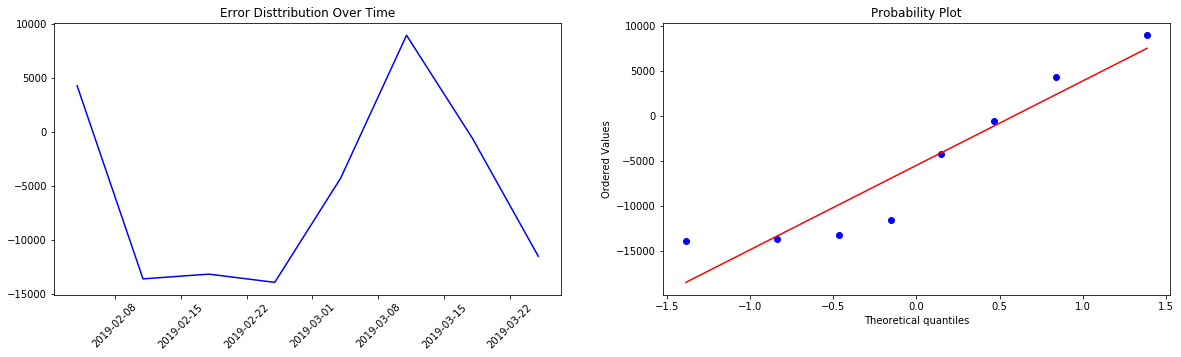

In [36]:
import pyramid as pm
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.xticks(rotation=45)
plt.plot(test.Error, color='blue')
plt.title('Error Disttribution Over Time')
plt.subplot(122)
scipy.stats.probplot(test.Error, plot=plt)
plt.show()

In [37]:
# Obtain predicted values
start = len(train)
end = len(train)+len(test)-1
predictions = results.predict(
    start=start, end=end, dynamic=False, typ='levels').rename('Predictions')

In [38]:
final = pd.DataFrame(predictions).join(test)

In [39]:
final.head()

,Predictions,Count,Predicted,Error
2019-02-04,200641.327599,194570,190282.514309,4287.485691
2019-02-11,212867.369212,193545,207165.140204,-13620.140204
2019-02-18,191871.735263,196149,209330.691465,-13181.691465
2019-02-25,202893.152409,190241,204185.997558,-13944.997558
2019-03-04,213443.527422,189141,193419.028761,-4278.028761


_What does the forecast look like?_

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(dfIndex['Count'], order=(0, 1, 2), seasonal_order=(
    0, 1, 1, 13), enforce_invertibility=False)
results = model.fit()
fcast = results.predict(len(dfIndex), len(dfIndex)+24,
                        typ='levels').rename('SARIMA Forecast')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


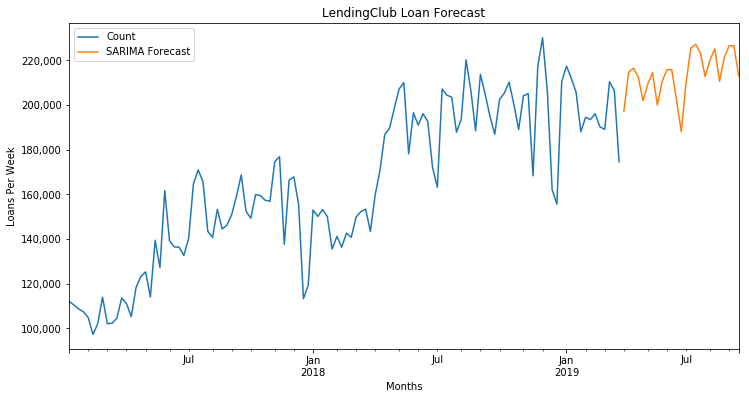

In [41]:
# Plot predictions against known values
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')
title = 'LendingClub Loan Forecast'
ylabel = 'Loans Per Week'
xlabel = 'Months' 
ax = dfIndex['Count'].plot(legend=True, figsize=(12, 6), title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)

--------------

# LSTM
We will use the same data for LSTM to predict 8 weeks of loans

Capable of learning long-term dependencies.  Remembering information for long periods of time. Chain of repeated moduls of neural networks.

sigmod funcion helps to determine what to keep, if it is a 1 keep other wise get rid of it.

In [42]:
import pandas as pd

df = pd.read_csv('RejectedLoans.csv')
df = df.dropna()
df.shape

(19158655, 2)

In [43]:
df = df.drop('Unnamed: 0', axis=1)

In [44]:
df.rename(columns={'Application Date': 'Application_Date'}, inplace=True)
df['Count'] = 1
df['Application_Date'] = pd.to_datetime(
    df['Application_Date']) - pd.to_timedelta(7, unit='d')
df = df.groupby([pd.Grouper(key='Application_Date', freq='W-MON')]
                )['Count'].sum().reset_index().sort_values('Application_Date')

In [45]:
#df = df.dropna()
df = df.loc[1:,:]
df.shape

(117, 2)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 1 to 117
Data columns (total 2 columns):
Application_Date    117 non-null datetime64[ns]
Count               117 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.7 KB


In [47]:
df.head()

,Application_Date,Count
1,2017-01-02,119903
2,2017-01-09,112116
3,2017-01-16,110457
4,2017-01-23,108717
5,2017-01-30,107435


In [48]:
dataset = df.values


_We will try to predict 8 weeks of loans_

In [49]:
dataset_train, dataset_test = df[0:109], df[109:117]

In [50]:
training_set = dataset_train.iloc[:, 1:2].values
testing_set = dataset_test.iloc[:, 1:2].values

In [51]:
dataset_train.info(), dataset_test.shape, training_set.shape, testing_set.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 1 to 109
Data columns (total 2 columns):
Application_Date    109 non-null datetime64[ns]
Count               109 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.6 KB


(None, (8, 2), (109, 1), (8, 1))

In [52]:
dataset_train.isna().sum()
dataset_test.isna().sum()

Application_Date    0
Count               0
dtype: int64

In [53]:
dataset_test.head()

,Application_Date,Count
110,2019-02-04,194570
111,2019-02-11,193545
112,2019-02-18,196149
113,2019-02-25,190241
114,2019-03-04,189141


In [54]:
training_set.shape

(109, 1)

In [55]:
dataset_train.shape

(109, 2)

In [56]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(testing_set)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


I am predicting the next 2 months (8 weeks)

I am predicting 109-8 because the first 8 I can't predict becasue there isn't anyting behind it to predict. therefore (101,8,1)

In [57]:
#create matrix
X_train = []
y_train = []
for i in range(8, 109):#8 time steps to figure out the next step
    X_train.append(training_set_scaled[i-8:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [58]:
X_test = []
y_test = []
for i in range(0,8):
    X_test.append(testing_set_scaled[i-0:i, 0])
    y_test.append(testing_set_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [59]:
#matrix has 101 rows and 8 columns
#and trying to figure out the next step
#after the 8 time steps

#I am using the previous 8 time step(week) to predict the 9th time step(week)
X_train.shape,X_test.shape

((101, 8, 1), (8, 0, 1))

In [60]:
#!pip install keras
#!pip install tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


_To prevent overfitting(wrong connections) I will randomly disable some neurons. 3 layer with 1 output. Adam learning rate will be used and 10 epoch(back and forths that are done)__


3 layers and outputing 1
adam learning rate of NN

epocs number of back and forths
batch is 60

In [61]:
regressor = Sequential()

regressor.add(LSTM(units = 90, return_sequences = True, 
                   input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.5))
regressor.add(LSTM(units = 90, return_sequences = True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units = 90, return_sequences = True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units = 90))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))   
              
regressor.compile(optimizer = 'adam', 
                  loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 500, batch_size = 5)

W0628 16:09:06.731936 4554114496 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0628 16:09:06.757803 4554114496 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0628 16:09:06.762686 4554114496 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0628 16:09:06.992039 4554114496 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:13

Epoch 1/500
101/101 [==============================] - 3s 33ms/step - loss: 0.1094
Epoch 2/500
101/101 [==============================] - 1s 7ms/step - loss: 0.0348
Epoch 3/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0344
Epoch 4/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0412
Epoch 5/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0313
Epoch 6/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0239
Epoch 7/500
101/101 [==============================] - 1s 7ms/step - loss: 0.0294
Epoch 8/500
101/101 [==============================] - 1s 7ms/step - loss: 0.0235
Epoch 9/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0241
Epoch 10/500
101/101 [==============================] - 1s 7ms/step - loss: 0.0254
Epoch 11/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0299
Epoch 12/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0375
Epoch 13/500

101/101 [==============================] - 1s 8ms/step - loss: 0.0175
Epoch 100/500
101/101 [==============================] - 1s 8ms/step - loss: 0.0231
Epoch 101/500
101/101 [==============================] - 1s 7ms/step - loss: 0.0180
Epoch 102/500
101/101 [==============================] - 1s 7ms/step - loss: 0.0188
Epoch 103/500
101/101 [==============================] - 1s 7ms/step - loss: 0.0217
Epoch 104/500
101/101 [==============================] - 1s 7ms/step - loss: 0.0249
Epoch 105/500
101/101 [==============================] - 1s 7ms/step - loss: 0.0196
Epoch 106/500
101/101 [==============================] - 1s 7ms/step - loss: 0.0185
Epoch 107/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0226
Epoch 108/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0188
Epoch 109/500
101/101 [==============================] - 1s 8ms/step - loss: 0.0183
Epoch 110/500
101/101 [==============================] - 1s 7ms/step - loss: 0.0208
Epoch 

101/101 [==============================] - 1s 6ms/step - loss: 0.0148
Epoch 197/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0164
Epoch 198/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0185
Epoch 199/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0170
Epoch 200/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0165
Epoch 201/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0201
Epoch 202/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0190
Epoch 203/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0183
Epoch 204/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0163
Epoch 205/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0204
Epoch 206/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0167
Epoch 207/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0188
Epoch 

101/101 [==============================] - 1s 6ms/step - loss: 0.0151
Epoch 294/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0134
Epoch 295/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0149
Epoch 296/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0149
Epoch 297/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0200
Epoch 298/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0129
Epoch 299/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0164
Epoch 300/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0140
Epoch 301/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0142
Epoch 302/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0161
Epoch 303/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0135
Epoch 304/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0158
Epoch 

101/101 [==============================] - 1s 6ms/step - loss: 0.0124
Epoch 391/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0104
Epoch 392/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0139
Epoch 393/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0112
Epoch 394/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0134
Epoch 395/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0121
Epoch 396/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0111
Epoch 397/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0122
Epoch 398/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0121
Epoch 399/500
101/101 [==============================] - 1s 7ms/step - loss: 0.0122
Epoch 400/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0112
Epoch 401/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0125
Epoch 

101/101 [==============================] - 1s 6ms/step - loss: 0.0086
Epoch 488/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0079
Epoch 489/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0090
Epoch 490/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0089
Epoch 491/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0086
Epoch 492/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0088
Epoch 493/500
101/101 [==============================] - 1s 7ms/step - loss: 0.0099
Epoch 494/500
101/101 [==============================] - 1s 7ms/step - loss: 0.0078
Epoch 495/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0084
Epoch 496/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0078
Epoch 497/500
101/101 [==============================] - 1s 6ms/step - loss: 0.0074
Epoch 498/500
101/101 [==============================] - 1s 8ms/step - loss: 0.0089
Epoch 

In [62]:
rejected_loan_count = dataset_test.iloc[:, 1:2].values

In [63]:
rejected_loan_count

array([[194570],
       [193545],
       [196149],
       [190241],
       [189141],
       [210487],
       [206549],
       [174618]])

In [64]:
dataset_train.shape, dataset_test.shape

((109, 2), (8, 2))

In [65]:
dataset_total = pd.concat((dataset_train['Count'],
                           dataset_test['Count']),
                          axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 8:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
inputs

array([[ 0.88084418],
       [-0.34832306],
       [-0.52861803],
       [ 1.00094789],
       [ 1.19546126],
       [ 1.04329644],
       [ 0.87066827],
       [ 0.37567259],
       [ 0.55624634],
       [ 0.52767013],
       [ 0.60026764],
       [ 0.43555717],
       [ 0.40489002],
       [ 1.        ],
       [ 0.8902116 ],
       [ 0.        ]])

In [66]:
X_test = []
for i in range(8, 16):
    X_test.append(inputs[i-8:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_loans = regressor.predict(X_test)
predicted_loans = sc.inverse_transform(predicted_loans)

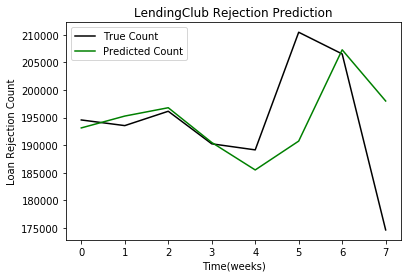

RMSE Train Score: 2815.62 
MSE Train Score: 7927718.85 

RMSE Test Score: 10935.81 
MSE Test Score: 119591873.43 


In [70]:

plt.plot(rejected_loan_count, color='black', label='True Count')
plt.plot(predicted_loans, color='green', label='Predicted Count')
plt.title('LendingClub Rejection Prediction')
plt.xlabel('Time(weeks)')
plt.ylabel('Loan Rejection Count')
plt.legend()
plt.show();

# make predictions
import math
trainPredict = regressor.predict(X_train)
testPredict = regressor.predict(X_test)
# invert predictions
trainPredict = sc.inverse_transform(trainPredict)
trainY = sc.inverse_transform([y_train])
testPredict = sc.inverse_transform(testPredict)
testY = sc.inverse_transform([y_test])
# calculate root mean squared error
trainScore1 = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('RMSE Train Score: %.2f ' % (trainScore1))
trainScore2 = mean_squared_error(trainY[0], trainPredict[:,0])
print('MSE Train Score: %.2f ' % (trainScore2))

testScore3 = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('\nRMSE Test Score: %.2f ' % (testScore3))
testScore4 = mean_squared_error(testY[0], testPredict[:,0])
print('MSE Test Score: %.2f ' % (testScore4))


_From the plot the model didn't do that well, it is overfitting.  It is predicting more rejections. The root mean square of the  actual and the predicted are not close at all._